In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import utils, optimization, metrics, plot
import pickle

# Parameters

In [3]:
spix = 256
path = '../data/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [4]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [5]:
nsamples = 1000
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])

In [6]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us plot 16 images

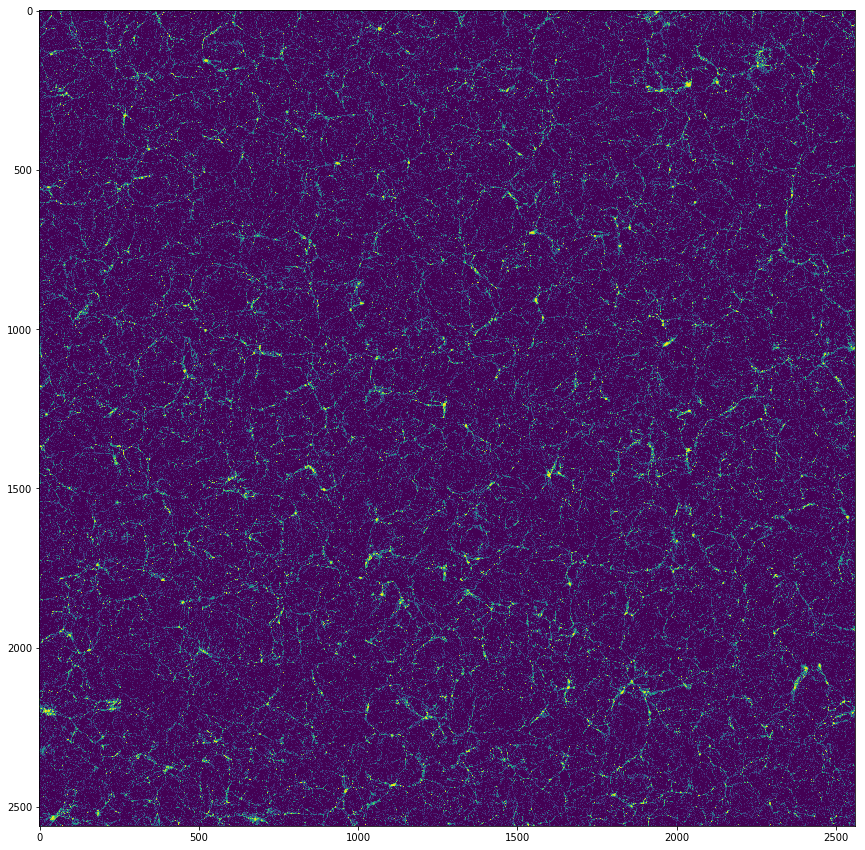

In [7]:
plt.figure(figsize=(15,15))
utils.draw_images(input_img,nx=10,ny=10,px=spix,py=spix)

Let us make small patches of 64 :-)

In [8]:
ns = 64
cut = spix//ns
img_small = np.zeros([nsamples*cut*cut, ns, ns])
for i in range(cut):
    for j in range(cut):
        k = j + i*cut 
        img_small[k*nsamples:(k+1)*nsamples,:,:] = input_img[:,i*ns:(i+1)*ns,j*ns:(j+1)*ns]


# # Reduce the size
# ns = 64
# cut = spix//ns
# img_small = input_img[:,:ns,:ns].copy()
# del input_img

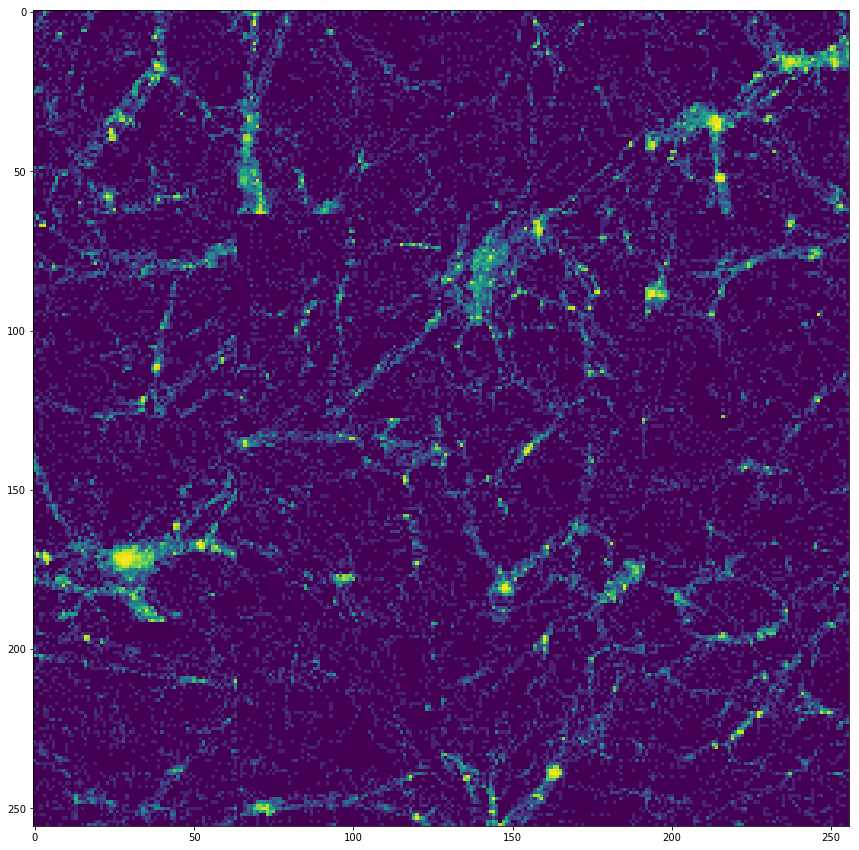

In [9]:
plt.figure(figsize=(15,15))
utils.draw_images(img_small,nx=4,ny=4,px=ns,py=ns)

# A) Train a small GAN

In [10]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)

time_str = current_time_str()


In [11]:
latent_dim = 100

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 64]
params_discriminator['shape'] = [[5, 5],[5, 5], [3, 3]]
params_discriminator['batch_norm'] = [True, True, True]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True

params_encoder = dict()
params_encoder['stride'] = [2, 2]
params_encoder['nfilter'] = [8, 16]
params_encoder['shape'] = [[5, 5],[5, 5]]
params_encoder['batch_norm'] = [True, True]

params_generator = dict()
params_generator['stride'] = [2, 2, 2]
params_generator['latent_dim'] = latent_dim
params_generator['nfilter'] = [64, 32, 1]
params_generator['shape'] = [[3, 3],[5, 5], [5, 5]]
params_generator['batch_norm'] = [True, True]
params_generator['full'] = [8*8*64]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'
params_generator['upsampling'] = 4
params_generator['encoder'] = params_encoder

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['weight_l2'] = 0.1
params_optimization['batch_size'] = 16
params_optimization['optimizer'] = 'adam' # rmsprop / adam
params_optimization['disc_learning_rate'] = 1e-5
params_optimization['gen_learning_rate'] = 1e-5
params_optimization['beta1'] = 0.99
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 50

params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['encoder'] = params_encoder
params['optimization'] = params_optimization

params['image_size'] = [ns, ns]
params['sum_every'] = 200
params['viz_every'] = 200
params['save_every'] = 2000
global_path = '../../saved_result/UPWGAN/'+ time_str +'_size_{}/'.format(ns)
params['summary_dir'] = global_path + 'summary/'
params['save_dir'] = global_path + 'checkpoints/'

params['clip_max_real'] = False
params['log_clip'] = 0.1
params['sigma_smooth'] = 1
params['k'] = k





In [12]:
from model import gan_upsampler
from gan import WGAN_upsampler


wgan_upsampler_model = gan_upsampler()
obj = WGAN_upsampler(params, wgan_upsampler_model)

Encoder block 
------------------------------------------------------------
     ENCODER:  The input is of size (?, 16, 16, 1)
     ENCODER: 0 Conv layer with 8 channels
         Batch norm
         ENCODER:  Size of the conv variables: (?, 8, 8, 8)
     ENCODER: 1 Conv layer with 16 channels
         Batch norm
         ENCODER:  Size of the conv variables: (?, 4, 4, 16)
     ENCODER:  Size of the conv variables: (?, 256)
     Latent:  Size of the Z variables: (?, 100)
------------------------------------------------------------

Generator 
------------------------------------------------------------
     The input is of size (?, 356)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 8, 8, 64)
     1 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 16, 16, 64)
     2 Deconv layer with 32 channels
         Batch norm
         Size of the variables: (?, 32, 32, 32)
     3 Deconv layer with 1 channels
  

In [13]:
obj.train(img_small)


Epoch: [ 0] [  99/1000] Counter:100	( 1.4 min	19.22 examples/sec	0.832 sec/batch)	L_Disc:123.48292542	L_Gen:5.49014997
Epoch: [ 0] [ 199/1000] Counter:200	( 3.4 min	13.14 examples/sec	1.218 sec/batch)	L_Disc:33.67256546	L_Gen:4.89212227
 [*] [Fake, Real] Min [7.415, 0.194],	Median [17.876,1.202],	Mean [1.555E+03,3.580E+00],	 Max [1.001E+06,2.856E+02],	 Var [3.469E+09,2.367E+02]
 [*] [Comp, Fake, Real] PeakDistance:[6.075, 0.320, 0.108]	CrossPS:[-52.356, -97.241, -15.779]	PSD_Diff:9147976.253
 [*] New PSD Low achieved 9147976.252733 (was 10000000000.000000)
Epoch: [ 0] [ 399/1000] Counter:400	( 7.6 min	13.20 examples/sec	1.212 sec/batch)	L_Disc:11.92085075	L_Gen:6.04528236
 [*] [Fake, Real] Min [6.431, 0.166],	Median [14.219,1.030],	Mean [1.538E+01,2.299E+00],	 Max [5.340E+01,1.484E+02],	 Var [2.736E+01,5.640E+01]
 [*] [Comp, Fake, Real] PeakDistance:[4.837, 0.056, 0.196]	CrossPS:[1.295, 0.190, -2.590]	PSD_Diff:84395.322
 [*] New PSD Low achieved 84395.321659 (was 9147976.252733)
Epoch:

 [*] [Fake, Real] Min [0.439, 0.166],	Median [1.839,1.030],	Mean [2.056E+00,2.299E+00],	 Max [8.284E+00,1.484E+02],	 Var [1.138E+00,5.640E+01]
 [*] [Comp, Fake, Real] PeakDistance:[5.187, 0.233, 0.196]	CrossPS:[-3.349, -2.024, -2.590]	PSD_Diff:74168.784
 [*] New PSD Low achieved 74168.783826 (was 77396.156595)
Epoch: [ 3] [ 499/1000] Counter:3500	(71.6 min	12.55 examples/sec	1.275 sec/batch)	L_Disc:-1.54276979	L_Gen:0.89422369
Epoch: [ 3] [ 599/1000] Counter:3600	(73.6 min	13.11 examples/sec	1.220 sec/batch)	L_Disc:-0.84829986	L_Gen:0.86847067
 [*] [Fake, Real] Min [0.375, 0.180],	Median [1.732,0.921],	Mean [1.912E+00,2.214E+00],	 Max [7.539E+00,1.455E+02],	 Var [9.057E-01,5.594E+01]
 [*] [Comp, Fake, Real] PeakDistance:[3.573, 0.077, 0.174]	CrossPS:[4.096, 0.553, 16.466]	PSD_Diff:145193.130
Epoch: [ 3] [ 699/1000] Counter:3700	(75.8 min	12.52 examples/sec	1.277 sec/batch)	L_Disc:-1.31874955	L_Gen:0.73490512
Epoch: [ 3] [ 799/1000] Counter:3800	(77.8 min	13.34 examples/sec	1.200 sec/ba

 [*] [Fake, Real] Min [0.119, 0.180],	Median [0.840,0.921],	Mean [4.610E+03,2.214E+00],	 Max [1.744E+06,1.455E+02],	 Var [2.028E+10,5.594E+01]
 [*] [Comp, Fake, Real] PeakDistance:[1.152, 0.841, 0.174]	CrossPS:[14.046, -1.372, 16.466]	PSD_Diff:12558811.501
Epoch: [ 6] [ 699/1000] Counter:6700	(137.4 min	12.67 examples/sec	1.263 sec/batch)	L_Disc:-0.82326949	L_Gen:1.50406551
Epoch: [ 6] [ 799/1000] Counter:6800	(139.5 min	13.23 examples/sec	1.209 sec/batch)	L_Disc:-0.82779461	L_Gen:1.49116409
 [*] [Fake, Real] Min [0.125, 0.170],	Median [0.898,1.042],	Mean [1.480E+00,2.287E+00],	 Max [4.736E+01,1.441E+02],	 Var [8.388E+00,5.563E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.461, 0.257, 0.127]	CrossPS:[-7.186, -1.325, -13.140]	PSD_Diff:23417.974
 [*] New PSD Low achieved 23417.974477 (was 46707.019584)
Epoch: [ 6] [ 899/1000] Counter:6900	(141.6 min	12.49 examples/sec	1.281 sec/batch)	L_Disc:-1.06356239	L_Gen:1.26193166
Epoch: [ 6] [ 999/1000] Counter:7000	(143.6 min	13.46 examples/sec	1.1

Epoch: [ 9] [ 899/1000] Counter:9900	(203.4 min	12.46 examples/sec	1.284 sec/batch)	L_Disc:-0.88064438	L_Gen:0.83988678
Epoch: [ 9] [ 999/1000] Counter:10000	(205.4 min	13.35 examples/sec	1.199 sec/batch)	L_Disc:-0.82501119	L_Gen:1.40533471
 [*] [Fake, Real] Min [0.109, 0.189],	Median [0.824,1.124],	Mean [1.904E+00,3.064E+00],	 Max [6.729E+01,2.119E+02],	 Var [1.935E+01,1.162E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.361, 0.230, 0.087]	CrossPS:[-20.502, -18.819, -19.860]	PSD_Diff:40951.809
Epoch: [10] [  99/1000] Counter:10100	(207.5 min	12.68 examples/sec	1.261 sec/batch)	L_Disc:-0.77958453	L_Gen:1.20818341
Epoch: [10] [ 199/1000] Counter:10200	(209.6 min	13.27 examples/sec	1.205 sec/batch)	L_Disc:-0.99823403	L_Gen:1.68488324
 [*] [Fake, Real] Min [0.115, 0.194],	Median [0.851,1.202],	Mean [4.610E+03,3.580E+00],	 Max [1.001E+06,2.856E+02],	 Var [1.033E+10,2.367E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.576, 0.938, 0.108]	CrossPS:[-53.227, -99.321, -15.779]	PSD_Diff:1170496.297
E

 [*] [Fake, Real] Min [0.108, 0.194],	Median [0.810,1.202],	Mean [6.147E+03,3.580E+00],	 Max [2.903E+06,2.856E+02],	 Var [4.940E+10,2.367E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.272, 0.333, 0.108]	CrossPS:[-56.296, -100.175, -15.779]	PSD_Diff:15873144.355
Epoch: [13] [ 299/1000] Counter:13300	(273.0 min	12.79 examples/sec	1.251 sec/batch)	L_Disc:-0.79224551	L_Gen:2.99822903
Epoch: [13] [ 399/1000] Counter:13400	(275.0 min	13.43 examples/sec	1.191 sec/batch)	L_Disc:-0.62175262	L_Gen:1.65386391
 [*] [Fake, Real] Min [0.109, 0.166],	Median [0.811,1.030],	Mean [1.613E+00,2.299E+00],	 Max [4.073E+01,1.484E+02],	 Var [8.492E+00,5.640E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.131, 0.051, 0.196]	CrossPS:[-2.752, -3.219, -2.590]	PSD_Diff:16017.270
Epoch: [13] [ 499/1000] Counter:13500	(277.1 min	12.63 examples/sec	1.267 sec/batch)	L_Disc:-0.73332912	L_Gen:0.83160740
Epoch: [13] [ 599/1000] Counter:13600	(279.1 min	13.49 examples/sec	1.186 sec/batch)	L_Disc:-0.69947863	L_Gen:2.53090096
 

Epoch: [16] [ 499/1000] Counter:16500	(338.4 min	12.67 examples/sec	1.263 sec/batch)	L_Disc:-0.68759573	L_Gen:1.11508918
Epoch: [16] [ 599/1000] Counter:16600	(340.4 min	13.53 examples/sec	1.182 sec/batch)	L_Disc:-0.58293390	L_Gen:2.08166218
 [*] [Fake, Real] Min [0.112, 0.180],	Median [0.784,0.921],	Mean [7.682E+03,2.214E+00],	 Max [1.891E+06,1.455E+02],	 Var [3.845E+10,5.594E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.398, 0.427, 0.174]	CrossPS:[13.341, -14.020, 16.466]	PSD_Diff:8181942.346
Epoch: [16] [ 699/1000] Counter:16700	(342.5 min	12.80 examples/sec	1.250 sec/batch)	L_Disc:-1.15149331	L_Gen:5.12991762
Epoch: [16] [ 799/1000] Counter:16800	(344.5 min	13.33 examples/sec	1.200 sec/batch)	L_Disc:-0.71861410	L_Gen:1.50621581
 [*] [Fake, Real] Min [0.110, 0.170],	Median [0.992,1.042],	Mean [6.146E+03,2.287E+00],	 Max [1.744E+06,1.441E+02],	 Var [2.242E+10,5.563E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.420, 0.603, 0.127]	CrossPS:[-21.346, -106.701, -13.140]	PSD_Diff:4957785.349

 [*] [Fake, Real] Min [0.116, 0.170],	Median [0.841,1.042],	Mean [1.538E+03,2.287E+00],	 Max [1.001E+06,1.441E+02],	 Var [3.462E+09,5.563E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.366, 0.340, 0.127]	CrossPS:[-25.845, -88.175, -13.140]	PSD_Diff:16621802.619
Epoch: [19] [ 899/1000] Counter:19900	(407.9 min	12.65 examples/sec	1.265 sec/batch)	L_Disc:-0.63679796	L_Gen:1.38464379
Epoch: [19] [ 999/1000] Counter:20000	(409.8 min	13.60 examples/sec	1.177 sec/batch)	L_Disc:-0.53358579	L_Gen:-0.17281161
 [*] [Fake, Real] Min [0.112, 0.189],	Median [0.887,1.124],	Mean [6.148E+03,3.064E+00],	 Max [3.465E+06,2.119E+02],	 Var [1.384E+10,1.162E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.642, 0.873, 0.087]	CrossPS:[-62.095, -299.291, -19.860]	PSD_Diff:48050257.016
Epoch: [20] [  99/1000] Counter:20100	(412.0 min	12.55 examples/sec	1.275 sec/batch)	L_Disc:-0.61370242	L_Gen:3.78840828
Epoch: [20] [ 199/1000] Counter:20200	(414.0 min	13.29 examples/sec	1.203 sec/batch)	L_Disc:-0.62790996	L_Gen:3.769

Epoch: [23] [  99/1000] Counter:23100	(473.2 min	12.80 examples/sec	1.250 sec/batch)	L_Disc:-0.40954986	L_Gen:2.93530846
Epoch: [23] [ 199/1000] Counter:23200	(475.2 min	13.38 examples/sec	1.196 sec/batch)	L_Disc:-0.57111371	L_Gen:0.54749417
 [*] [Fake, Real] Min [0.121, 0.194],	Median [1.142,1.202],	Mean [5.223E+04,3.580E+00],	 Max [6.451E+06,2.856E+02],	 Var [5.213E+11,2.367E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.801, 1.100, 0.108]	CrossPS:[-19.382, -14.053, -15.779]	PSD_Diff:10965417.921
Epoch: [23] [ 299/1000] Counter:23300	(477.3 min	12.99 examples/sec	1.232 sec/batch)	L_Disc:-0.52126956	L_Gen:1.56678927
Epoch: [23] [ 399/1000] Counter:23400	(479.3 min	13.30 examples/sec	1.203 sec/batch)	L_Disc:-0.45601782	L_Gen:3.04263258
 [*] [Fake, Real] Min [0.121, 0.166],	Median [0.855,1.030],	Mean [1.756E+00,2.299E+00],	 Max [7.890E+01,1.484E+02],	 Var [1.947E+01,5.640E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.243, 0.080, 0.196]	CrossPS:[-1.645, -1.214, -2.590]	PSD_Diff:850.064
 [*]

Epoch: [26] [ 399/1000] Counter:26400	(540.4 min	13.44 examples/sec	1.191 sec/batch)	L_Disc:-0.47851458	L_Gen:2.81268764
 [*] [Fake, Real] Min [0.113, 0.166],	Median [0.960,1.030],	Mean [2.363E+00,2.299E+00],	 Max [1.070E+02,1.484E+02],	 Var [4.085E+01,5.640E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.173, 0.149, 0.196]	CrossPS:[-3.609, -4.199, -2.590]	PSD_Diff:1435.821
Epoch: [26] [ 499/1000] Counter:26500	(542.5 min	12.72 examples/sec	1.258 sec/batch)	L_Disc:-0.35222870	L_Gen:-0.16696760
Epoch: [26] [ 599/1000] Counter:26600	(544.4 min	13.54 examples/sec	1.182 sec/batch)	L_Disc:-0.41656446	L_Gen:2.75453091
 [*] [Fake, Real] Min [0.116, 0.180],	Median [0.810,0.921],	Mean [1.536E+04,2.214E+00],	 Max [3.702E+06,1.455E+02],	 Var [1.089E+11,5.594E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.330, 0.420, 0.174]	CrossPS:[22.947, -62.126, 16.466]	PSD_Diff:13364839.513
Epoch: [26] [ 699/1000] Counter:26700	(546.5 min	12.70 examples/sec	1.260 sec/batch)	L_Disc:-0.82093275	L_Gen:4.05593300
Epoc

Epoch: [29] [ 699/1000] Counter:29700	(607.7 min	12.76 examples/sec	1.254 sec/batch)	L_Disc:-0.35399395	L_Gen:3.31368208
Epoch: [29] [ 799/1000] Counter:29800	(609.7 min	13.41 examples/sec	1.193 sec/batch)	L_Disc:-0.47767004	L_Gen:0.34936321
 [*] [Fake, Real] Min [0.117, 0.170],	Median [0.998,1.042],	Mean [6.147E+03,2.287E+00],	 Max [1.452E+06,1.441E+02],	 Var [2.065E+10,5.563E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.354, 0.518, 0.127]	CrossPS:[3.407, -49.275, -13.140]	PSD_Diff:4902148.762
Epoch: [29] [ 899/1000] Counter:29900	(611.8 min	12.81 examples/sec	1.249 sec/batch)	L_Disc:-0.79435354	L_Gen:2.82867718
Epoch: [29] [ 999/1000] Counter:30000	(613.8 min	13.50 examples/sec	1.185 sec/batch)	L_Disc:-0.63410169	L_Gen:3.23310733
 [*] [Fake, Real] Min [0.113, 0.189],	Median [0.904,1.124],	Mean [1.075E+04,3.064E+00],	 Max [3.796E+06,2.119E+02],	 Var [4.418E+10,1.162E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.457, 0.751, 0.087]	CrossPS:[-65.441, -39.626, -19.860]	PSD_Diff:22387152.162

 [*] [Fake, Real] Min [0.117, 0.189],	Median [1.060,1.124],	Mean [1.690E+04,3.064E+00],	 Max [4.796E+06,2.119E+02],	 Var [9.072E+10,1.162E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.636, 0.995, 0.087]	CrossPS:[-66.802, -95.129, -19.860]	PSD_Diff:19165656.595
Epoch: [33] [  99/1000] Counter:33100	(676.9 min	12.68 examples/sec	1.262 sec/batch)	L_Disc:-0.54442543	L_Gen:1.93129563
Epoch: [33] [ 199/1000] Counter:33200	(678.9 min	13.24 examples/sec	1.208 sec/batch)	L_Disc:-0.56282258	L_Gen:2.86635947
 [*] [Fake, Real] Min [0.117, 0.194],	Median [0.823,1.202],	Mean [2.458E+04,3.580E+00],	 Max [4.637E+06,2.856E+02],	 Var [2.493E+11,2.367E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.362, 0.567, 0.108]	CrossPS:[-47.082, -68.876, -15.779]	PSD_Diff:2652998.936
Epoch: [33] [ 299/1000] Counter:33300	(681.0 min	12.94 examples/sec	1.237 sec/batch)	L_Disc:-0.38024718	L_Gen:2.07393146
Epoch: [33] [ 399/1000] Counter:33400	(683.0 min	13.33 examples/sec	1.200 sec/batch)	L_Disc:-0.41494852	L_Gen:0.775923

Epoch: [36] [ 299/1000] Counter:36300	(742.1 min	12.76 examples/sec	1.254 sec/batch)	L_Disc:-0.45669714	L_Gen:2.94409657
Epoch: [36] [ 399/1000] Counter:36400	(744.1 min	13.34 examples/sec	1.199 sec/batch)	L_Disc:-0.39007941	L_Gen:3.13040376
 [*] [Fake, Real] Min [0.114, 0.166],	Median [0.811,1.030],	Mean [1.538E+03,2.299E+00],	 Max [1.001E+06,1.484E+02],	 Var [3.469E+09,5.640E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.240, 0.245, 0.196]	CrossPS:[29.522, 77.568, -2.590]	PSD_Diff:16206363.811
Epoch: [36] [ 499/1000] Counter:36500	(746.2 min	12.71 examples/sec	1.259 sec/batch)	L_Disc:-0.63449895	L_Gen:4.26633215
Epoch: [36] [ 599/1000] Counter:36600	(748.2 min	13.45 examples/sec	1.189 sec/batch)	L_Disc:-0.40722045	L_Gen:4.08972216
 [*] [Fake, Real] Min [0.112, 0.180],	Median [0.951,0.921],	Mean [2.765E+04,2.214E+00],	 Max [6.243E+06,1.455E+02],	 Var [2.937E+11,5.594E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.382, 0.465, 0.174]	CrossPS:[22.371, -74.574, 16.466]	PSD_Diff:21385195.226
E

 [*] [Fake, Real] Min [0.124, 0.180],	Median [0.984,0.921],	Mean [2.920E+04,2.214E+00],	 Max [7.013E+06,1.455E+02],	 Var [3.733E+11,5.594E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.469, 0.498, 0.174]	CrossPS:[29.547, -66.650, 16.466]	PSD_Diff:22868686.692
Epoch: [39] [ 699/1000] Counter:39700	(811.7 min	12.73 examples/sec	1.257 sec/batch)	L_Disc:-0.27428281	L_Gen:2.04581642
Epoch: [39] [ 799/1000] Counter:39800	(813.7 min	13.35 examples/sec	1.199 sec/batch)	L_Disc:-0.38591820	L_Gen:3.38371825
 [*] [Fake, Real] Min [0.122, 0.170],	Median [0.899,1.042],	Mean [3.074E+03,2.287E+00],	 Max [2.003E+06,1.441E+02],	 Var [9.621E+09,5.563E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.372, 0.507, 0.127]	CrossPS:[-42.986, -157.314, -13.140]	PSD_Diff:39862777.076
Epoch: [39] [ 899/1000] Counter:39900	(815.8 min	12.97 examples/sec	1.233 sec/batch)	L_Disc:-0.38351414	L_Gen:3.97366309
Epoch: [39] [ 999/1000] Counter:40000	(817.8 min	13.28 examples/sec	1.204 sec/batch)	L_Disc:-0.47559652	L_Gen:2.797878

Epoch: [42] [ 899/1000] Counter:42900	(877.0 min	12.74 examples/sec	1.256 sec/batch)	L_Disc:-0.38866112	L_Gen:2.76107574
Epoch: [42] [ 999/1000] Counter:43000	(879.0 min	13.38 examples/sec	1.196 sec/batch)	L_Disc:-0.62972593	L_Gen:4.31981659
 [*] [Fake, Real] Min [0.113, 0.189],	Median [0.822,1.124],	Mean [6.147E+03,3.064E+00],	 Max [3.465E+06,2.119E+02],	 Var [1.385E+10,1.162E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.542, 0.730, 0.087]	CrossPS:[-74.022, -129.671, -19.860]	PSD_Diff:50181392.616
Epoch: [43] [  99/1000] Counter:43100	(881.1 min	12.74 examples/sec	1.256 sec/batch)	L_Disc:-0.35778159	L_Gen:4.97489452
Epoch: [43] [ 199/1000] Counter:43200	(883.0 min	13.59 examples/sec	1.178 sec/batch)	L_Disc:-0.44646233	L_Gen:3.66308212
 [*] [Fake, Real] Min [0.112, 0.194],	Median [1.052,1.202],	Mean [5.530E+04,3.580E+00],	 Max [7.822E+06,2.856E+02],	 Var [6.520E+11,2.367E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.531, 0.702, 0.108]	CrossPS:[-32.887, -10.126, -15.779]	PSD_Diff:10993554

 [*] [Fake, Real] Min [0.119, 0.194],	Median [0.920,1.202],	Mean [3.226E+04,3.580E+00],	 Max [5.174E+06,2.856E+02],	 Var [2.610E+11,2.367E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.657, 1.045, 0.108]	CrossPS:[-22.075, -7.473, -15.779]	PSD_Diff:3115282.220
Epoch: [46] [ 299/1000] Counter:46300	(946.4 min	12.83 examples/sec	1.248 sec/batch)	L_Disc:-0.57719553	L_Gen:2.19234419
Epoch: [46] [ 399/1000] Counter:46400	(948.4 min	13.23 examples/sec	1.209 sec/batch)	L_Disc:-0.43110058	L_Gen:1.66657853
 [*] [Fake, Real] Min [0.124, 0.166],	Median [0.885,1.030],	Mean [3.074E+03,2.299E+00],	 Max [1.381E+06,1.484E+02],	 Var [1.159E+10,5.640E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.255, 0.272, 0.196]	CrossPS:[24.119, 103.768, -2.590]	PSD_Diff:15523546.572
Epoch: [46] [ 499/1000] Counter:46500	(950.4 min	12.86 examples/sec	1.244 sec/batch)	L_Disc:-0.67735833	L_Gen:3.43740678
Epoch: [46] [ 599/1000] Counter:46600	(952.5 min	13.24 examples/sec	1.209 sec/batch)	L_Disc:-0.37467510	L_Gen:3.87644625


Epoch: [49] [ 499/1000] Counter:49500	(1011.7 min	12.78 examples/sec	1.252 sec/batch)	L_Disc:-0.46211007	L_Gen:1.89549816
Epoch: [49] [ 599/1000] Counter:49600	(1013.6 min	13.38 examples/sec	1.196 sec/batch)	L_Disc:-0.36060825	L_Gen:2.91550279
 [*] [Fake, Real] Min [0.124, 0.180],	Median [0.819,0.921],	Mean [1.690E+04,2.214E+00],	 Max [4.266E+06,1.455E+02],	 Var [8.566E+10,5.594E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.518, 0.665, 0.174]	CrossPS:[34.229, -64.590, 16.466]	PSD_Diff:23249883.775
Epoch: [49] [ 699/1000] Counter:49700	(1015.7 min	12.69 examples/sec	1.261 sec/batch)	L_Disc:-0.41838798	L_Gen:3.25651217
Epoch: [49] [ 799/1000] Counter:49800	(1017.7 min	13.63 examples/sec	1.174 sec/batch)	L_Disc:-0.39238548	L_Gen:2.77954769
 [*] [Fake, Real] Min [0.126, 0.170],	Median [1.017,1.042],	Mean [3.074E+03,2.287E+00],	 Max [2.003E+06,1.441E+02],	 Var [9.621E+09,5.563E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.336, 0.450, 0.127]	CrossPS:[1.309, 136.271, -13.140]	PSD_Diff:38794534.

In [ ]:

gen_sample, gen_sample_raw = wveegan_obj.generate()
        

In [52]:
np.inf

inf

/data/.virtualenvs/fma/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


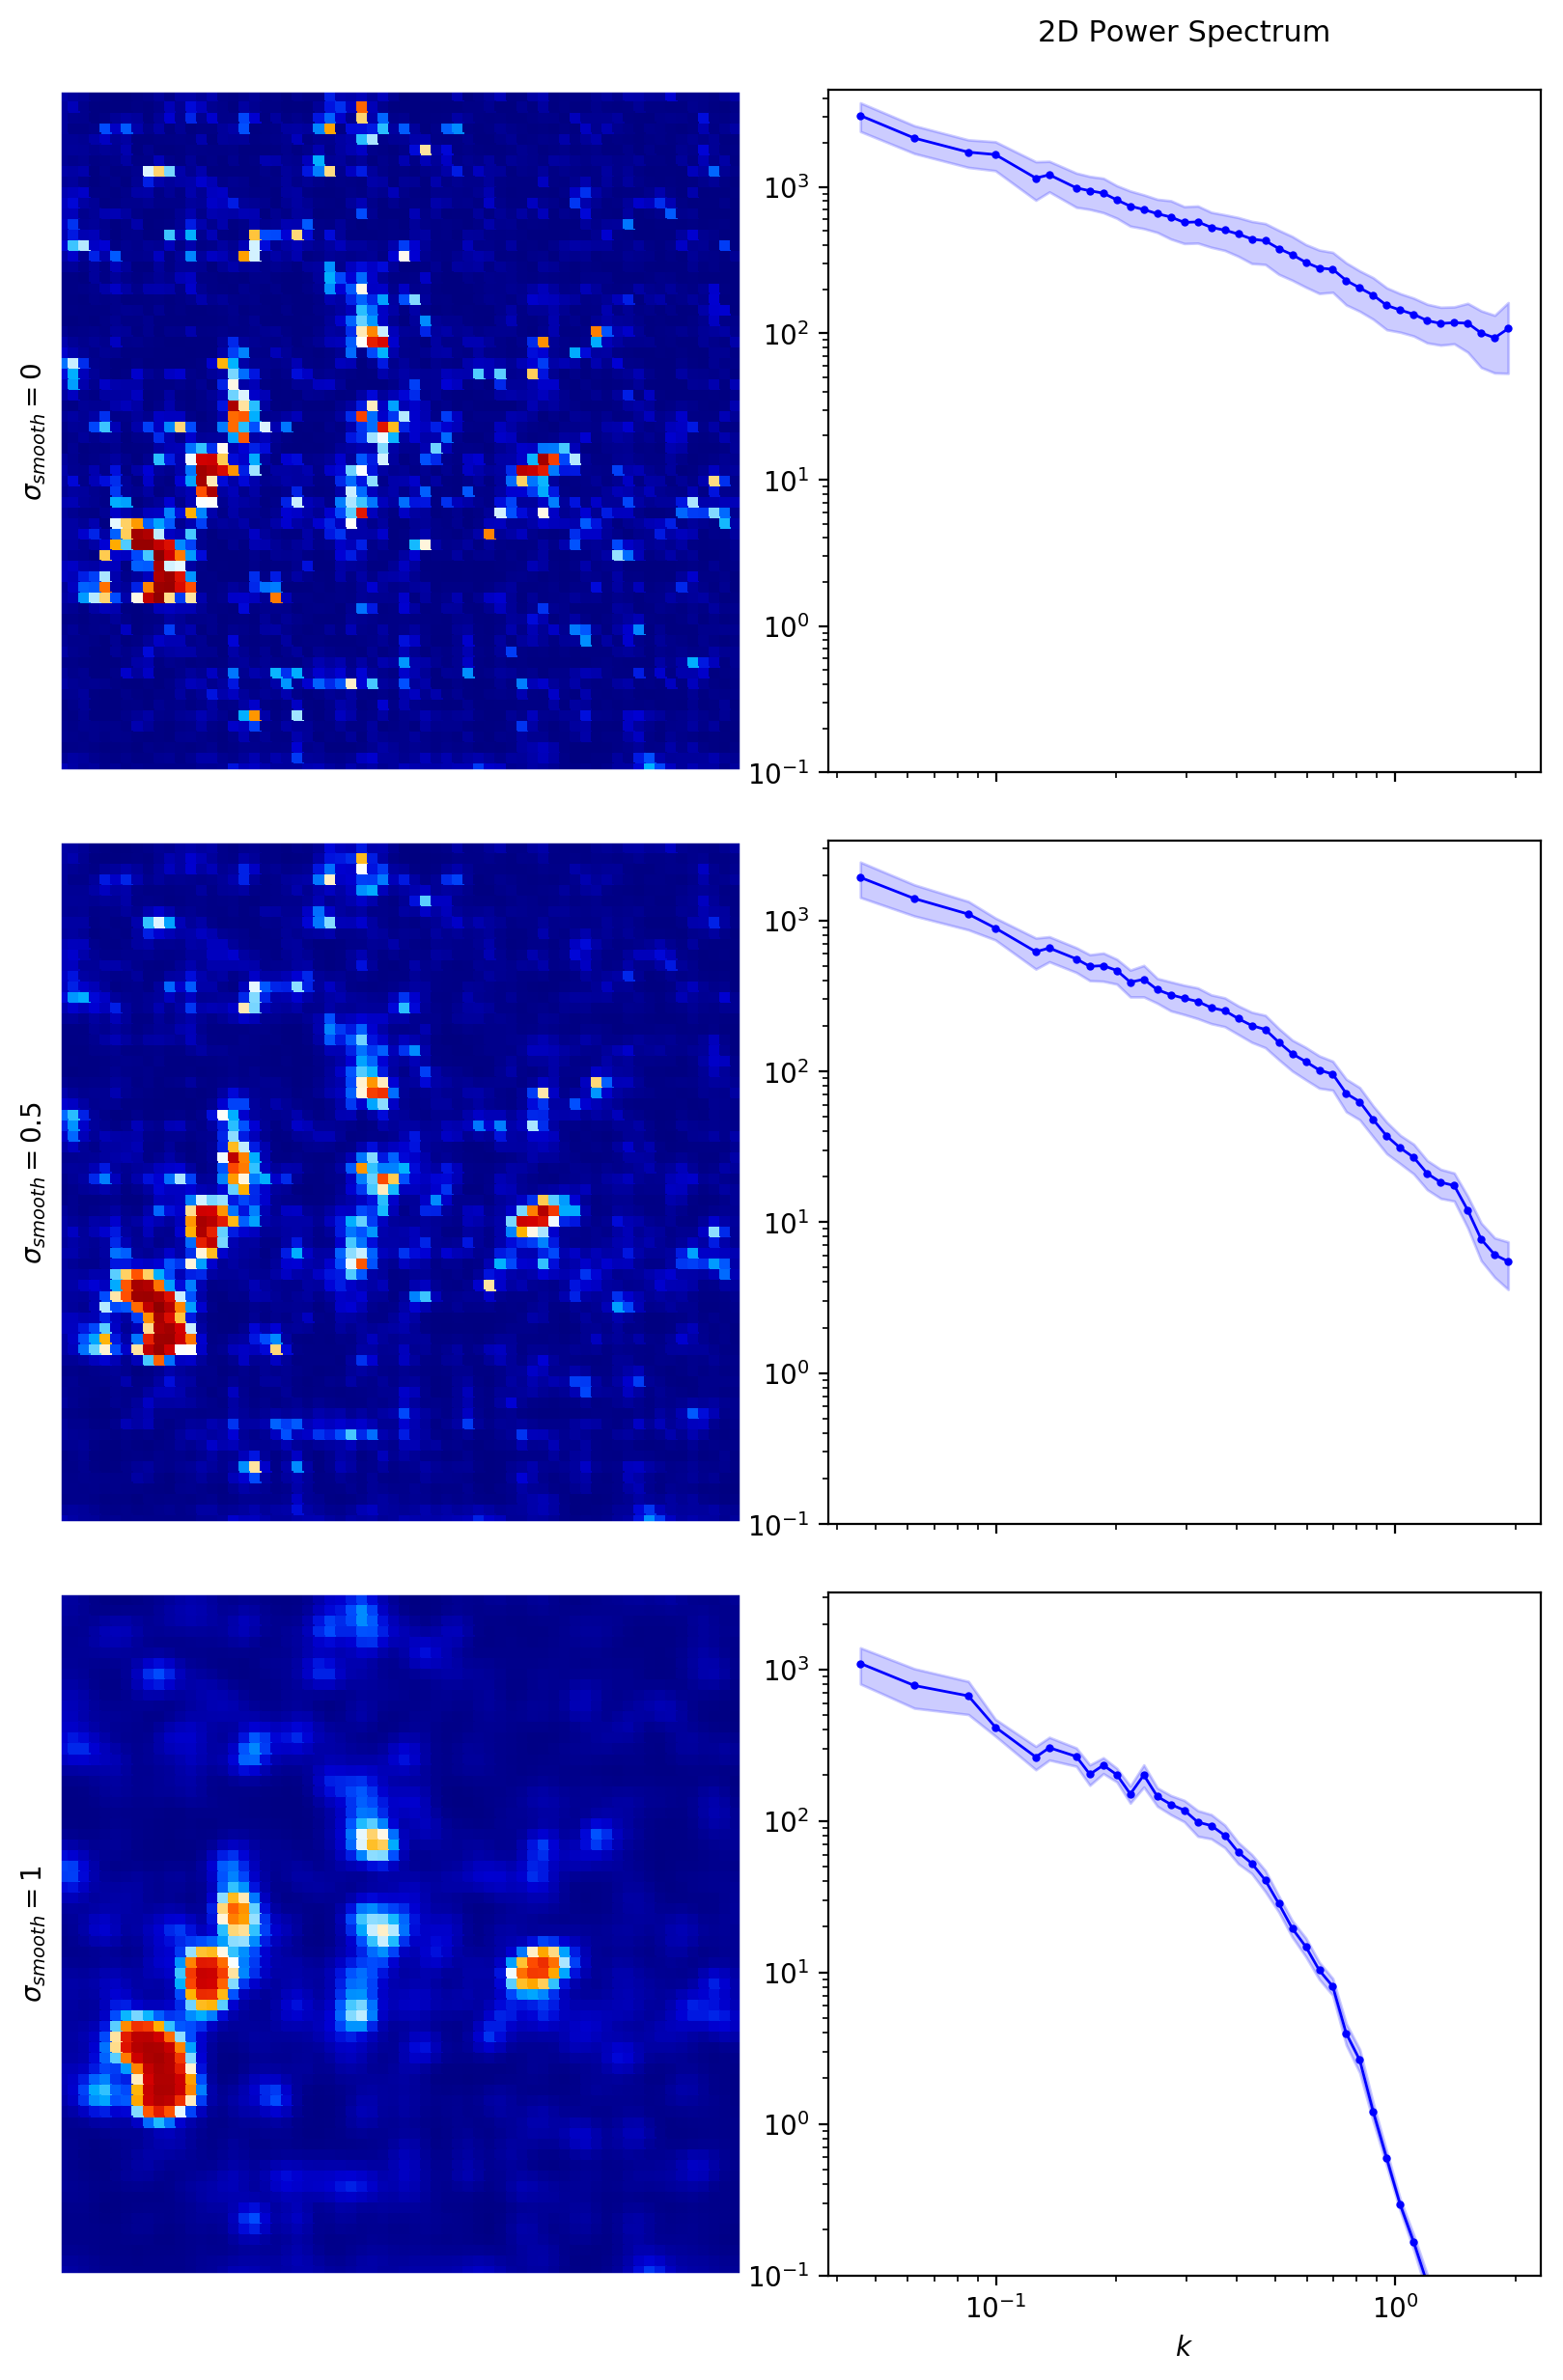

In [29]:
import plot

plot.plot_images_psd(gen_sample_raw,'' , sigma_smooth = [0,0.5,1])
